In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import numpy as np
import os


import seaborn as sns
sns.set_context("talk", font_scale=1.25) # "talk"

%matplotlib inline
%load_ext autoreload
%autoreload 2
#

Paper

1. --> Statistics about window length (make prediction time and window variable --> predictions should be same time)
Increase the training data.
2. --> U, V, G (ask Cristiana) -- can we predict MJO using -- Replace the scalar timeseries with 
4 component timeseries and then use the mapping to predict MJO
3. --> Z500 do DA (with GP)

## Autocorrelation

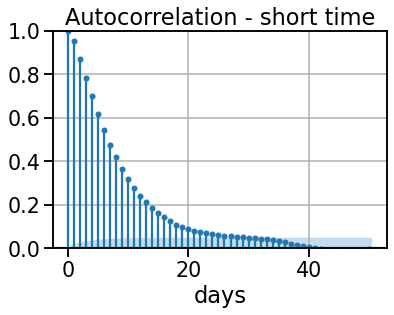

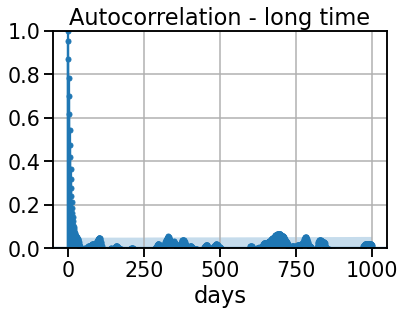

In [9]:
from statsmodels.graphics import tsaplots

entire_data = np.load('amplitude_data.npy')
entire_data=entire_data[1675:]
idx = np.where(entire_data > 1e34)[0]
assert idx.size == 0

fig = tsaplots.plot_acf(entire_data, lags=50)
plt.ylim(0,1)
plt.title("Autocorrelation - short time")
plt.xlabel('days')
plt.grid('Both')
plt.savefig('ac-short.png', bbox_inches='tight')
plt.show()

fig = tsaplots.plot_acf(entire_data, lags=1000)
plt.ylim(0,1)
plt.title("Autocorrelation - long time")
plt.xlabel('days')
plt.grid('Both')
plt.savefig('ac-long.png', bbox_inches='tight')
plt.show()

(17621,)
(9710,) (7621,)


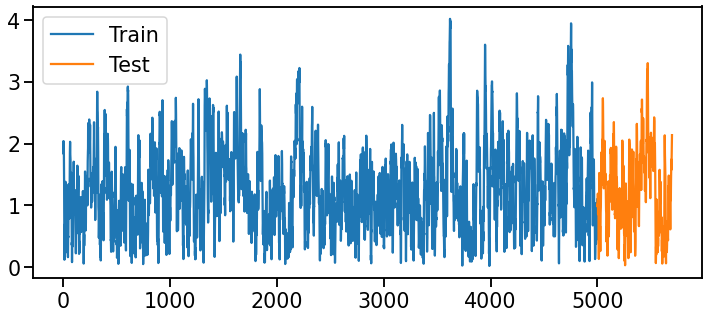

In [3]:
data = {}
entire_data = np.load('amplitude_data.npy')
print(entire_data.shape)
data['train'] = entire_data[:10000]
data['test'] = entire_data[10000:]
idx = np.where(data['train'] > 1e34)[0]
data['train'] = np.delete(data['train'], idx)
print(data['train'].shape, data['test'].shape)

N_train = 5000
N_forecast = 700
Ztrain = data['train'][:N_train] 
Ztest = data['train'][N_train:N_train+N_forecast]
# data['train'] = np.load(f'{datadir}/amplitude_data.npy').T
# data['test'] = np.load(f'{datadir}/Z500_Test_Snapshots.npy').T

plt.figure(figsize=(12, 5))
plt.plot(np.arange(N_train), Ztrain)
plt.plot(np.arange(N_train, N_train+N_forecast), Ztest)
plt.legend(['Train', 'Test'])

In [4]:
def rolling(a, window):
    shape = (a.size - window + 1, window)
    strides = (a.itemsize, a.itemsize)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
#         self.
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
#         covar_x = gpytorch.kernels.RBFKernel(x) + gpytorch.white_noise_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

/opt/homebrew/Caskroom/miniconda/base/envs/scientific/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5479381084442139 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/scientific/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.7500810623168945 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/opt/homebrew/Caskroom

Model with rolling window of 30 was tranined


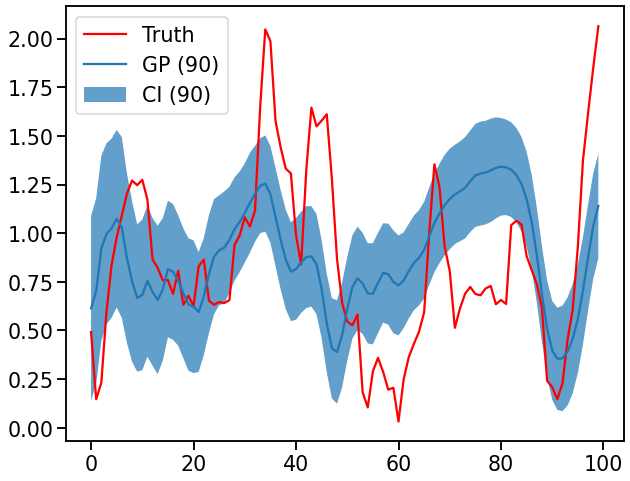

In [6]:
# rolling_widths = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# plot_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
#               'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
rolling_widths = [30]

plot_colors = ['tab:blue']

#plot_colors = ['tab:blue']

f, ax = plt.subplots(1, 1, figsize=(10, 8))
prediction_window  = 100
fixed_offset = 500
fixed_start = 200
dict_predictions ={}
dict_lower_confidence={}
dict_upper_confidence={}

dict_models={}

ax.plot(np.arange(prediction_window),Ztest[fixed_start:fixed_start+prediction_window], 'r')
for rolling_width, col in zip(rolling_widths, plot_colors):
    Input_X = rolling(Ztrain[:-1], rolling_width)
    Output_Y = Ztrain[rolling_width:]
    x_np = torch.from_numpy(Input_X).float()
    y_np = torch.from_numpy(Output_Y).float()
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
# gpytorch.likelihoods.FixedNoiseGaussianLikelihood()
    model = ExactGPModel(x_np, y_np, likelihood)
    model = model.to(torch.float)
    
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else 200

# Find optimal model hyperparameter
    model.train()
    likelihood.train()

# Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
# "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(training_iter):
       
        
    # Zero gradients from previous iteration
        optimizer.zero_grad()
    # Output from model
        output = model(x_np)
    # Calc loss and backprop gradients
        loss = -1*mll(output, y_np)
        loss.backward()
#         print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#              i + 1, training_iter, loss.item(),
#              model.covar_module.base_kernel.lengthscale.item(),
#             model.likelihood.noise.item() ))
        optimizer.step()
        
    dict_models[str(rolling_width)]=model
    print("Model with rolling window of {:} was tranined".format(rolling_width))
    predictions = np.zeros(prediction_window)
    lower_confidence = np.zeros(prediction_window)
    upper_confidence = np.zeros(prediction_window)
    temp = np.copy(Ztest[:prediction_window+fixed_offset-1])
    temp = rolling(temp, rolling_width)
    model.eval()
    likelihood.eval()
    fixed_start = 200
    for i in range(prediction_window):
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            temp1 = temp[i+fixed_start - rolling_width,:]
            if(i != 0):
                temp1[-1] = observed_pred.mean.numpy()
            test_x = torch.from_numpy(temp1.reshape((1, rolling_width))).float()
            observed_pred = likelihood(model(test_x))
#         print(observed_pred)
            lower, upper = observed_pred.confidence_region()
            predictions[i] = observed_pred.mean.numpy()
            lower_confidence[i] = lower.detach().numpy()
            upper_confidence[i] = upper.detach().numpy()
    
    dict_predictions[rolling_width] = predictions
    dict_lower_confidence[rolling_width] = lower_confidence
    dict_upper_confidence[rolling_width] = upper_confidence
    ax.plot(np.arange(prediction_window), predictions, col)
    ax.fill_between(np.arange(prediction_window), lower_confidence, 
                     upper_confidence, alpha=0.7)
# y_np = torch.from_numpy(Output_Y)
# Input_X = rolling(Ztrain[:-1], rolling_width)
# print(Input_X.shape)
# Output_Y = Ztrain[rolling_width:]
# print(Output_Y.shape)
# x_np = torch.from_numpy(Input_X)
# y_np = torch.from_numpy(Output_Y)
# print(Input_X)
# #Increase rolling_width 
# #Increase number of training points

# ax.legend(['Truth','GP (30)', 'CI (30)', 'GP(90)', 'CI (90)', 'GP (150)', 'CI (150)' ])
ax.legend(['Truth','GP (90)', 'CI (90)'])
# ax.legend(['Truth','GP (30)'])
# ax.set_ylim([-1.0, 1.0])
plt.show()

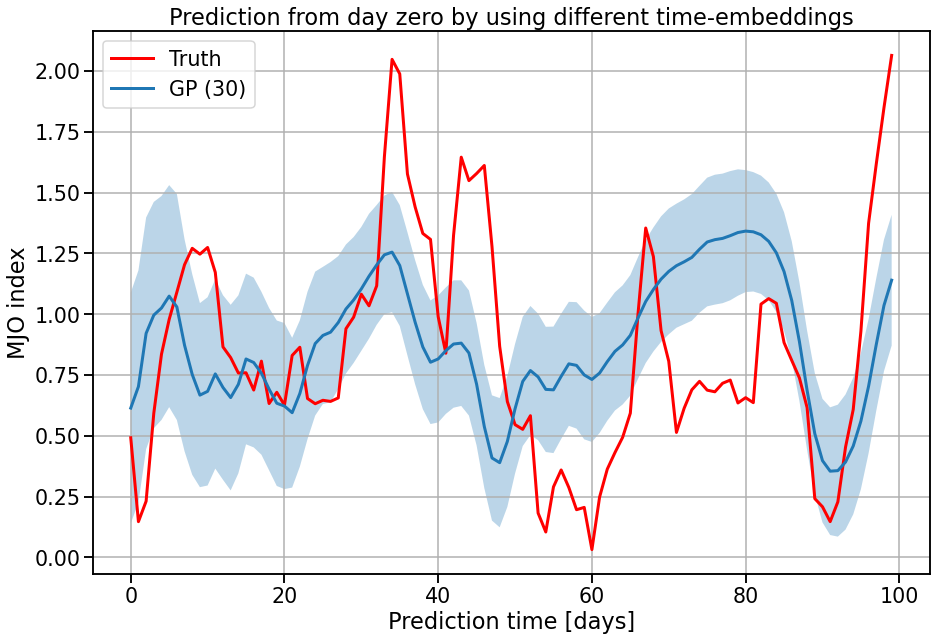

In [7]:
fig = plt.figure(figsize=(15, 10))

x_window=np.arange(prediction_window)
y_true=Ztest[fixed_start:fixed_start+prediction_window]
rolling_widths=[30]
plt.plot(x_window, y_true, 'r',lw=3,label='Truth')
for rolling_width, col in zip(rolling_widths, plot_colors):
    model=dict_models[str(rolling_width)]
    predictions = np.zeros(prediction_window)
    lower_confidence = np.zeros(prediction_window)
    upper_confidence = np.zeros(prediction_window)
    temp = np.copy(Ztest[:prediction_window+fixed_offset-1])
    temp = rolling(temp, rolling_width)
    model.eval()
    likelihood.eval()
    fixed_start = 200
    for i in range(prediction_window):
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            temp1 = temp[i+fixed_start - rolling_width,:]
            if(i != 0):
                temp1[-1] = observed_pred.mean.numpy()
            test_x = torch.from_numpy(temp1.reshape((1, rolling_width))).float()
            observed_pred = likelihood(model(test_x))
#         print(observed_pred)
            lower, upper = observed_pred.confidence_region()
            predictions[i] = observed_pred.mean.numpy()
            lower_confidence[i] = lower.detach().numpy()
            upper_confidence[i] = upper.detach().numpy()
    
    dict_predictions[rolling_width] = predictions
    dict_lower_confidence[rolling_width] = lower_confidence
    dict_upper_confidence[rolling_width] = upper_confidence
    plt.plot(x_window, predictions, 'tab:blue',lw=3,label="GP ({:})".format(rolling_width))
    plt.fill_between(x_window, lower_confidence, 
                     upper_confidence, alpha=0.3)
plt.title('Prediction from day zero by using different time-embeddings')
plt.ylabel('MJO index')
plt.xlabel('Prediction time [days]')
plt.legend()
plt.grid('both')
plt.savefig('Predictions-30_2.png', bbox_inches='tight')
plt.show()


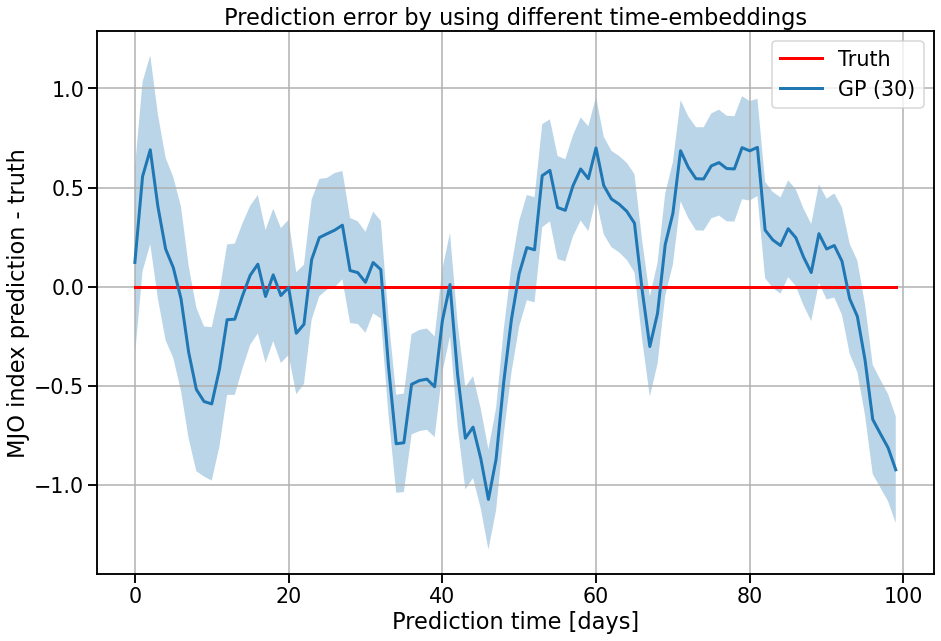

In [8]:
fig = plt.figure(figsize=(15, 10))

x_window=np.arange(prediction_window)
y_true=Ztest[fixed_start:fixed_start+prediction_window]

plt.plot(x_window, y_true-y_true, 'r',lw=3,label='Truth')
for rolling_width, col in zip(rolling_widths, plot_colors):
    model=dict_models[str(rolling_width)]
    predictions = np.zeros(prediction_window)
    lower_confidence = np.zeros(prediction_window)
    upper_confidence = np.zeros(prediction_window)
    temp = np.copy(Ztest[:prediction_window+fixed_offset-1])
    temp = rolling(temp, rolling_width)
    model.eval()
    likelihood.eval()
    fixed_start = 200
    for i in range(prediction_window):
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            temp1 = temp[i+fixed_start - rolling_width,:]
            if(i != 0):
                temp1[-1] = observed_pred.mean.numpy()
            test_x = torch.from_numpy(temp1.reshape((1, rolling_width))).float()
            observed_pred = likelihood(model(test_x))
#         print(observed_pred)
            lower, upper = observed_pred.confidence_region()
            predictions[i] = observed_pred.mean.numpy()
            lower_confidence[i] = lower.detach().numpy()
            upper_confidence[i] = upper.detach().numpy()
    
    dict_predictions[rolling_width] = predictions
    dict_lower_confidence[rolling_width] = lower_confidence
    dict_upper_confidence[rolling_width] = upper_confidence
    plt.plot(x_window, predictions-y_true, 'tab:blue',lw=3,label="GP ({:})".format(rolling_width))
    plt.fill_between(x_window, lower_confidence-y_true, 
                     upper_confidence-y_true, alpha=0.3)


plt.title('Prediction error by using different time-embeddings')
plt.ylabel('MJO index prediction - truth')
plt.xlabel('Prediction time [days]')
plt.legend()
plt.grid('both')
plt.savefig('error-30.png', bbox_inches='tight')
plt.show()
